In [1]:
import json
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,15)

from numpy import cov
from scipy.stats import pearsonr
from scipy.stats import spearmanr

import gc
from tqdm import tqdm_notebook
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings("ignore")
from functools import partial
import statsmodels.api as sm

import scipy as sp
from math import sqrt
from IPython.display import display 
from time import time

from yellowbrick.regressor import CooksDistance

import pingouin as pg

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,15)
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
with open("configuration.json", 'rt') as infile:
    config = json.load(infile)


sources = [os.path.join(config['paths']['output'], 
                        d['name'], 
                        'data.csv') for d in config['sources']]

sources

['prm-datasets/processed/worldbank\\data.csv',
 'prm-datasets/processed/emdat\\data.csv',
 'prm-datasets/processed/displacement\\data.csv',
 'prm-datasets/processed/mixedmigration\\data.csv',
 'prm-datasets/processed/UNHCR\\data.csv',
 'prm-datasets/processed/ACLED\\data.csv',
 'prm-datasets/processed/FIW\\data.csv',
 'prm-datasets/processed/WHO\\data.csv',
 'prm-datasets/processed/SystemicPeace\\data.csv',
 'prm-datasets/processed/PoliticalTerror\\data.csv',
 'prm-datasets/processed/WFP\\data.csv',
 'prm-datasets/processed/Polity\\data.csv',
 'prm-datasets/processed/VDem\\data.csv',
 'prm-datasets/processed/corruption\\data.csv',
 'prm-datasets/processed/UCDP\\data.csv',
 'prm-datasets/processed/FragileStates\\data.csv']

In [4]:
# Generate a data frame with all indicators
df = pd.concat((pd.read_csv(f) for f in sources), sort=False, ignore_index=True)

# Summary stats
print("Sources            : {}".format(len(sources)))
print("Shape              : {} (rows) {} (columns)".format(*df.shape))
print("Geographies        : {}".format(len(df['Country Name'].unique())))
print("Indicators         : {}".format(len(df['Indicator Code'].unique())))
print("Temporal coverage  : {} -> {}".format(df.year.min(), df.year.max()))
print("Null values        : {}".format(sum(df['value'].isnull())))



# Now arrange data in long form
data = pd.pivot_table(df, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')

# Consider country/year as features (and not an index)
data.reset_index(inplace=True)

Sources            : 16
Shape              : 936990 (rows) 8 (columns)
Geographies        : 503
Indicators         : 122
Temporal coverage  : 1789 -> 2019
Null values        : 1410


In [5]:
countries = ['AFG', 'MMR']

# Features
idx = ['Country Code', 'year']
mm = ['ETH.TO.{}'.format(i) for i in ['DNK', 'GBR', 'ITA', 'SAU', 'SWE', 'ZAF']]
endo = ['UNHCR.OUT.AS', 'UNHCR.OUT.IDP', 'UNHCR.OUT.OOC', 
        'UNHCR.OUT.REF', 'UNHCR.OUT.RET', 'UNHCR.OUT.RETIDP', 'IDP', 'UNHCR.EDP']
# missing entirely
emdat = ['EMDAT.CPX.OCCURRENCE','EMDAT.CPX.TOTAL.DEATHS','EMDAT.CPX.TOTAL.AFFECTED','EMDAT.CPX.AFFECTED',
         'SI.POV.GINI', 'ER.H2O.INTR.PC']
target = ['DRC.TOT.DISP']
features = list(set(data.columns.tolist()) - set(idx + mm + endo + target + emdat))

# filter
c1 = data['Country Code'].isin(countries)
c2 = data.year >= 1950

df = data.loc[c1 & c2, idx + features + target]
print("Filtered data has {} rows, {} columns.".format(*df.shape))

Filtered data has 140 rows, 104 columns.


In [6]:
df

Indicator Code,Country Code,year,SE.ADT.LITR.ZS,SP.SF.MAG.VIOL,ACLED.FATALITIES,WHO.OOP.HLTH.EXP,VDEM.FRD.POL.KILL,EG.ELC.ACCS.ZS,EMDAT.NAT.AFFECTED,WHO.TB.CAS,...,SP.EW.MAG.AREA,FSI.GRP.GRI,WHO.NUM.TB.CAS,SP.SF.MAG.FAIL,VDEM.FRD.REL,DRC.CORR.INDEX,SP.PV.CIV.WAR,EMDAT.NAT.OCCURRENCE,EMDAT.NAT.TOTAL.DAMAGE,DRC.TOT.DISP
234,AFG,1950,NaN,NaN,NaN,NaN,-0.195,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,-0.948,NaN,0.0,NaN,NaN,NaN
235,AFG,1951,NaN,NaN,NaN,NaN,-0.195,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,-0.948,NaN,0.0,NaN,NaN,NaN
236,AFG,1952,NaN,0.0,NaN,NaN,-0.195,NaN,NaN,NaN,...,0.0,NaN,NaN,0.0,-0.948,NaN,0.0,NaN,NaN,NaN
237,AFG,1953,NaN,0.0,NaN,NaN,-0.195,NaN,NaN,NaN,...,0.0,NaN,NaN,0.0,-0.948,NaN,0.0,NaN,NaN,NaN
238,AFG,1954,NaN,0.0,NaN,NaN,-0.195,NaN,NaN,NaN,...,0.0,NaN,NaN,0.0,-0.948,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20941,MMR,2015,NaN,0.0,NaN,73.9,0.131,60.500000,1635703.0,138447.0,...,2.0,9.7,191000.0,0.0,-0.604,22.0,0.0,6.0,119000.0,1156864.0
20942,MMR,2016,75.551201,0.0,NaN,NaN,-0.047,57.009384,941297.0,137551.0,...,2.0,9.9,191000.0,0.0,-0.594,30.0,0.0,7.0,16600.0,1190527.0
20943,MMR,2017,NaN,0.0,NaN,NaN,-0.200,NaN,199520.0,NaN,...,1.0,9.7,NaN,0.0,-0.868,30.0,0.0,2.0,NaN,1832945.0
20944,MMR,2018,NaN,NaN,NaN,NaN,-0.113,NaN,NaN,NaN,...,NaN,9.8,NaN,NaN,-0.462,NaN,0.0,2.0,NaN,1576700.0


In [7]:
def explain(data, indicator):
    sub_df = data.loc[~(data[indicator].isna())]
    year_from = np.nan_to_num(sub_df['year'].min())
    year_to = np.nan_to_num(sub_df['year'].max())
    #years = np.nan_to_num(sub_df['year'].count())
    #count = np.nan_to_num(data[indicator].count())
    #min = np.nan_to_num(data[indicator].min())
    #max = np.nan_to_num(data[indicator].max())
    #mean = np.nan_to_num(data[indicator].mean())
    #std = np.nan_to_num(data[indicator].std())
    #nan = np.nan_to_num(data[indicator].isna().sum())
    count = np.nan_to_num(sub_df[indicator].count())
    min = np.nan_to_num(sub_df[indicator].min())
    max = np.nan_to_num(sub_df[indicator].max())
    mean = np.nan_to_num(sub_df[indicator].mean())
    std = np.nan_to_num(sub_df[indicator].std())
    nan = np.nan_to_num(sub_df[indicator].isna().sum())
    percent = nan/(count+nan)*100
    outliers = data.loc[((np.abs(data[indicator]-data[indicator].mean()) > (3*data[indicator].std())))][indicator].dropna().count()
    #print(outliers)
    if outliers > 0:
        outliers = True
    else:
        outliers = False 
        
    significant_rise = []
    significant_fall = []
        
    if len(sub_df[indicator].values)>0:       
    
        diff_sum=0 
        stored = sub_df[indicator].values[0]
        year_before = sub_df['year'].values[0]
        i=0
        for v, y in zip(sub_df[indicator], sub_df['year']):
            dif =  v - stored
            if y-year_before==1:
                diff_sum=diff_sum+np.abs(dif)   
            stored = v
            year_before = y
            i+=1
        avg=diff_sum/i
        
        #avg = (max-min)/2
    
        stored = sub_df[indicator].values[0]
        year_before = sub_df['year'].values[0]
        for v, y in zip(sub_df[indicator], sub_df['year']):
            dif =  v - stored
            if y-year_before==1:
                if np.abs(dif) >= (avg)*2:
                    if dif>0:
                        significant_rise.append([y,v])
                    else:
                        significant_fall.append([y,v])                    
            stored = v
            year_before = y
   
    
    
    #print(significant)       
    
    #print("count=%d\nmin=%d\nmax=%d\nmean=%d\nstd=%d\nouliers=%r\nyears covered %d-%d" % (count, min, max, mean,std, outliers, year_from, year_to))
    return count, min, max, mean,std, nan,percent, outliers, year_from, year_to, significant_rise, significant_fall

In [8]:
def cook_dist(data, i, max_lag=1):
    sub_df = data.loc[~(data[i].isna())]
    sub_df = sub_df.loc[~(sub_df['DRC.TOT.DISP'].isna())]
    X = np.column_stack((sub_df[i].values, sub_df['year'].values))
    #print(X)
    y = sub_df['DRC.TOT.DISP'].values
    for j in range(0,max_lag):
        visualizer = CooksDistance()
        visualizer.fit(X, y)
        visualizer.show()
        if len(y)>2:
            X=X[:-1]
            y=y[1:]        
            z = zip(visualizer.distance_, X[:,1])
            top = sorted(z, reverse=True)[:3]
            print("Lag = "+str(j)+str(top))


## Get change values by indicator

In [9]:
#For Cook's Distance and plotting
def get_changes_target(data, indicator):
    sub_df = data.loc[~(data[indicator].isna())]
    sub_df = sub_df.loc[~(sub_df['DRC.TOT.DISP'].isna())]
    target = []
    differences_indicator = []
    years = []
        
    if len(sub_df[indicator].values)>0:       
    
        stored = sub_df[indicator].values[0]
        year_before = sub_df['year'].values[0]
        i=0
        for v, y in zip(sub_df[indicator], sub_df['year']):
            dif =  v - stored
            if y-year_before==1:
                differences_indicator.append(dif)
                years.append(y)
            stored = v
            year_before = y
            i+=1   
        stored = sub_df['DRC.TOT.DISP'].values[0]
        year_before = sub_df['year'].values[0]
        i=0
        for v, y in zip(sub_df['DRC.TOT.DISP'], sub_df['year']):
            dif =  v - stored
            if y-year_before==1:
                target.append(dif)
            stored = v
            year_before = y
            i+=1  

    differences_indicator = np.column_stack((differences_indicator, years))
    target = target[:len(differences_indicator)]
        
    return differences_indicator, target


def get_changes(data, indicator):
    sub_df = data.loc[~(data[indicator].isna())]
   
    differences_indicator = []
    years = []
        
    if len(sub_df[indicator].values)>0:       
    
        stored = sub_df[indicator].values[0]
        year_before = sub_df['year'].values[0]
        for v, y in zip(sub_df[indicator], sub_df['year']):
            dif =  v - stored
            if y-year_before==1:
                differences_indicator.append(dif)
                years.append(y)
            stored = v
            year_before = y
            
    differences_indicator = np.column_stack((differences_indicator, years))
    
        
    return differences_indicator
    

In [10]:
result_df = pd.DataFrame(columns = ['Indicator Name', 'n',  'r2',  
                                    'pearson corr', 'spearman corr', 'lag'])
changes_df = pd.DataFrame(columns=df.columns, index=df.index) 
changes_df.year = df.year
changes_df['Country Code'] = df['Country Code']
#changes_df = changes_df.set_index('year')
for i in features+list(['DRC.TOT.DISP']):
    for c in countries:
        sub_df = df.loc[df['Country Code']==c]
        X = get_changes(sub_df, i)
        for ch in X:                  
            #changes_df[i].at[ ch[1]] =  ch[0]  
            changes_df.loc[(changes_df['year'] == ch[1]) & (changes_df['Country Code'] == c) ,i] = ch[0] 
 
    '''count = np.nan_to_num(data[i].count())
    if count>10:
        try:
            X, y = get_changes_target(data, i)
            for j in range(0,5):
                pearson, _ = pearsonr(X[:, 0], y)
                spear, _ = spearmanr(X[:, 0], y)
                res = pg.corr(X[:, 0], y).reset_index()
                new_row = {'Indicator Name':i,  'n':res.n.values[0], 
                       'r2':res.r2.values[0], 
                       'pearson corr':pearson, 'spearman corr':spear, 'lag':j}
                result_df=result_df.append(new_row, ignore_index=True)
                X=X[:-1]
                y=y[1:] 
            #new_row = {'indicator':i, 'value':X[:, 0], 'year':X[:, 1], 'target':y} 

        except:
            continue
     
            
    '''
    

## Remove columns with no data (grouped by countries)

In [11]:
remove = []
for country in countries:
    sub = changes_df.loc[df['Country Code'] == country]
    for c in sub.columns:
        if sub[c].isnull().all():
            remove.append(c)
features = list(set(features) - set(remove))


In [12]:
'''#result_df = result_df.loc[result_df['n']>30]
result_df = result_df.sort_values(by='r2', ascending=False)
result_df = result_df.head(25)
result_df.to_csv('MMR.csv')'''

"#result_df = result_df.loc[result_df['n']>30]\nresult_df = result_df.sort_values(by='r2', ascending=False)\nresult_df = result_df.head(25)\nresult_df.to_csv('MMR.csv')"

In [13]:
'''top_displacement = result_df['Indicator Name'].values[:10]
lags = result_df['lag'].values[:10]

data['DRC.TOT.DISP'] = data['DRC.TOT.DISP'].apply(lambda x: (x - np.mean(data['DRC.TOT.DISP'])) / (np.max(data['DRC.TOT.DISP']) - np.min(data['DRC.TOT.DISP'])))


for j in range(0,10):
    i = top_displacement[j]
    
    data[i] = data[i].apply(lambda x: (x - np.mean(data[i])) / (np.max(data[i]) - np.min(data[i])))
    years = data.year
    plt.plot(years,data[i].values)
    years = [x+lags[j] for x in years]
    plt.plot(years,data[i].values)
    plt.plot(data.year,data['DRC.TOT.DISP'].values)  
    plt.title(df.loc[df["Indicator Code"]==i]["Indicator Name"].unique()+" Lag = "+str(lags[j]))
    plt.legend([i, i+' lag', 'DRC.TOT.DISP'],loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()'''

'top_displacement = result_df[\'Indicator Name\'].values[:10]\nlags = result_df[\'lag\'].values[:10]\n\ndata[\'DRC.TOT.DISP\'] = data[\'DRC.TOT.DISP\'].apply(lambda x: (x - np.mean(data[\'DRC.TOT.DISP\'])) / (np.max(data[\'DRC.TOT.DISP\']) - np.min(data[\'DRC.TOT.DISP\'])))\n\n\nfor j in range(0,10):\n    i = top_displacement[j]\n    \n    data[i] = data[i].apply(lambda x: (x - np.mean(data[i])) / (np.max(data[i]) - np.min(data[i])))\n    years = data.year\n    plt.plot(years,data[i].values)\n    years = [x+lags[j] for x in years]\n    plt.plot(years,data[i].values)\n    plt.plot(data.year,data[\'DRC.TOT.DISP\'].values)  \n    plt.title(df.loc[df["Indicator Code"]==i]["Indicator Name"].unique()+" Lag = "+str(lags[j]))\n    plt.legend([i, i+\' lag\', \'DRC.TOT.DISP\'],loc=\'center left\', bbox_to_anchor=(1, 0.5))\n    plt.show()'

In [14]:
'''data['DRC.TOT.DISP'] = data['DRC.TOT.DISP'].apply(lambda x: (x - np.mean(data['DRC.TOT.DISP'])) / (np.max(data['DRC.TOT.DISP']) - np.min(data['DRC.TOT.DISP'])))
for i in indicators:
    sub_df = data.loc[~(data[i].isna())]
    #print( sub_df[i].values)
    if len(sub_df[i].values)>1:
        data[i] = data[i].apply(lambda x: (x - np.mean(data[i])) / (np.max(data[i]) - np.min(data[i])))
    else:
        continue
    sub_df2 = changes_df.loc[~(changes_df[i].isna())]
    #print( sub_df[i].values)
    if len(sub_df2[i].values)>1:
        changes_df[i] = changes_df[i].apply(lambda x: (x - np.mean(changes_df[i])) / (np.max(changes_df[i]) - np.min(changes_df[i])))
    else:
        continue
    count, min, max, mean,std, nan,percent, outliers, year_from, year_to, significant_rise,significant_fall = explain(data, i)
    #count, min, max, mean,std, nan,percent, outliers, year_from, year_to, significant_rise,significant_fall = explain(changes_df, i)
    #print(mean, std)
    plt.plot(data.year,data[i].values,marker='o')
    plt.plot(changes_df.index,changes_df[i].values,marker='o', color='g')
    #print(changes_df.year)
    
    #print(std, significant)
   
    plt.plot(data.year,data['DRC.TOT.DISP'].values)
 
    

    plt.title(i)
    plt.legend([i, 'changes','DRC.TOT.DISP'],loc='center left', bbox_to_anchor=(1, 0.5))
   
    plt.show()
    '''

"data['DRC.TOT.DISP'] = data['DRC.TOT.DISP'].apply(lambda x: (x - np.mean(data['DRC.TOT.DISP'])) / (np.max(data['DRC.TOT.DISP']) - np.min(data['DRC.TOT.DISP'])))\nfor i in indicators:\n    sub_df = data.loc[~(data[i].isna())]\n    #print( sub_df[i].values)\n    if len(sub_df[i].values)>1:\n        data[i] = data[i].apply(lambda x: (x - np.mean(data[i])) / (np.max(data[i]) - np.min(data[i])))\n    else:\n        continue\n    sub_df2 = changes_df.loc[~(changes_df[i].isna())]\n    #print( sub_df[i].values)\n    if len(sub_df2[i].values)>1:\n        changes_df[i] = changes_df[i].apply(lambda x: (x - np.mean(changes_df[i])) / (np.max(changes_df[i]) - np.min(changes_df[i])))\n    else:\n        continue\n    count, min, max, mean,std, nan,percent, outliers, year_from, year_to, significant_rise,significant_fall = explain(data, i)\n    #count, min, max, mean,std, nan,percent, outliers, year_from, year_to, significant_rise,significant_fall = explain(changes_df, i)\n    #print(mean, std)\n    p

In [15]:
'''corrs = changes_df.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, cmap='Spectral_r', mask=mask, square=True, vmin=-.5, vmax=.5)
plt.title('Correlation matrix')'''

"corrs = changes_df.corr()\nmask = np.zeros_like(corrs)\nmask[np.triu_indices_from(mask)] = True\nsns.heatmap(corrs, cmap='Spectral_r', mask=mask, square=True, vmin=-.5, vmax=.5)\nplt.title('Correlation matrix')"

In [16]:
'''train_df = changes_df.loc[changes_df.index<2018]
train_df = train_df.fillna(method='ffill').fillna(method='bfill')
test_df = changes_df.loc[changes_df.index==2018]
test_df = test_df.fillna(method='ffill').fillna(method='bfill')

train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

yt = train_df['DRC.TOT.DISP'].values
yv = test_df['DRC.TOT.DISP'].values

xt = train_df[indicators].values
xv = test_df[indicators].values

print("Train shape: X"+str(xt.shape)+" y"+str(yt.shape))
print("Test shape: X"+str(xv.shape)+" y"+str(yv.shape))'''

'train_df = changes_df.loc[changes_df.index<2018]\ntrain_df = train_df.fillna(method=\'ffill\').fillna(method=\'bfill\')\ntest_df = changes_df.loc[changes_df.index==2018]\ntest_df = test_df.fillna(method=\'ffill\').fillna(method=\'bfill\')\n\ntrain_df = train_df.fillna(0)\ntest_df = test_df.fillna(0)\n\nyt = train_df[\'DRC.TOT.DISP\'].values\nyv = test_df[\'DRC.TOT.DISP\'].values\n\nxt = train_df[indicators].values\nxv = test_df[indicators].values\n\nprint("Train shape: X"+str(xt.shape)+" y"+str(yt.shape))\nprint("Test shape: X"+str(xv.shape)+" y"+str(yv.shape))'

In [17]:
'''from sklearn.linear_model import LinearRegression
from sklearn import metrics

regressor = LinearRegression()  
regressor.fit(xt, yt)

y_pred = regressor.predict(xv)

print(yv, y_pred)'''

'from sklearn.linear_model import LinearRegression\nfrom sklearn import metrics\n\nregressor = LinearRegression()  \nregressor.fit(xt, yt)\n\ny_pred = regressor.predict(xv)\n\nprint(yv, y_pred)'

In [18]:
def lag_variables(data, var, lag):
    """
    Append lagged variables to frame.
    
    data - pandas data frame
    var - list of variable names to lag
    lag - integer
    
    """
    idx_cols = ['year', 'Country Code']
    fv = var + idx_cols
    
    tmp = data[fv].copy(deep=True)
    
    col_name = [v + ".T" + "{0:+}".format(lag) for v in var]
    
    tmp.rename(columns={k: v for (k, v) in zip(var, col_name)},
               inplace=True)
    tmp.year -= lag
    data = pd.merge(data, tmp, on=idx_cols, how='left')
    
    return data, col_name


def generate_features(data, 
                      training_years,
                      forecast_year,
                      country,
                      target_var,
                      feature_var):
    """ 
    Generate a feature set for training/test
    
    data: pandas Dataframe in long form with all indicator variables
    training_years: Tuple showing min-max years to train on, e.g. (1995, 2010)
    forecast_year: test year, (2011)
    country: ISO3 code (e.g. 'AFG')
    target_var: variable name to forecast e.g. 'FD'
    feature_var: list of variables to include

    returns: 
        Dictionary with training, test data, along with the baseline
        Baseline is the latest flow in the training data.
    """
    
    true_feature_var = [f for f in feature_var]
    print("Total # Features: {}".format(len(true_feature_var)))
    
    dcols = data.columns
    assert target_var in dcols,\
        "Target variable '{}' must be in data frame.".format(target_var)
    
    for fv in feature_var:
        assert fv in dcols,\
            "Feature variable '{}' does not exist.".format(fv)
        
    # Get the poor man's forecast as baseline
    dt = forecast_year - training_years[1]
    bv = data.loc[(data.year == forecast_year - dt) & 
                  (data['Country Code'] == country), target_var].values[0]
    print("Baseline value: {} (year {})".format(bv, forecast_year - dt))
    
    # Get the true value
    tr = data.loc[(data.year == forecast_year) & 
                  (data['Country Code'] == country), target_var].values[0]
    print("True value: {} (year {})".format(tr, forecast_year))
    
    # Target variable offset by a year (y_(t+dt))
    data, varname = lag_variables(data, [target_var], dt)
    true_target_var = varname[0]
    
    # Temporal filter: since the target variable is lagged, the training
    # year is one year prior.
    yl, yu = training_years
    t1 = data.year.between(*(yl, yu - dt))
    v1 = data.year == forecast_year - dt 
    
    # Spatial filter
    t2 = data['Country Code'] == country
        
    # For an AR(1) we just include current year value
    #true_feature_var += [target_var]

    # Handle the missing features
    data = data.fillna(method='ffill').fillna(method='bfill')
    
    # Training data
    Xt = data.loc[t1 & t2, true_feature_var]
    yt = data.loc[t1 & t2, true_target_var]
    
    # Forecast/validation data
    Xv = data.loc[v1 & t2, true_feature_var]
    yv = data.loc[v1 & t2, true_target_var]
    
    # Drop missing training labels
    idx = ~pd.isnull(yt)
    yt = yt[idx]
    Xt = Xt[idx]
    
    return {'data': (Xt, yt, Xv, yv), 'baseline': bv, 'true': tr, 'Country code': c}

In [19]:
# Variables to predict
TARGETS = ['DRC.TOT.DISP']

# Years ahead to predict
lag = [1, 2, 3, 4]
PERIODS = [{'train_years': (1995, Y - lg), 
            'predict_year': Y,
            'lag': lg} for Y in np.arange(2010, 2019, 1) for lg in lag]

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn import metrics
# Models to evaluate
MODELS = [('XGBoost-0.1', Pipeline([("Preprocessor", SimpleImputer(strategy='mean')),
                                ("Estimator", GradientBoostingRegressor(n_estimators=500, 
                                                                 max_depth=6, 
                                                                 learning_rate=0.1, 
                                                                 loss='ls'))])),
          ('XGBoost-0.001', Pipeline([("Preprocessor", SimpleImputer(strategy='mean')),
                                ("Estimator", GradientBoostingRegressor(n_estimators=500, 
                                                                 max_depth=6, 
                                                                 learning_rate=0.001, 
                                                                 loss='ls'))])),
          ("Linear Regression", linear_model.LinearRegression()),
          ("Support Vector Regression", SVR(gamma='auto')),
        ]

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
results = []
for c in countries:
    for p in PERIODS:
        print('********')
              # Generate problem instance
        d = generate_features(changes_df, 
                  p['train_years'],
                  p['predict_year'],
                c,
                  "DRC.TOT.DISP",
                  features)

    
        Xt, yt, Xv, yv = d['data']
        #regressor = LinearRegression()  

        #regressor.fit(Xt, yt)
        #y_pred = regressor.predict(Xv)
        #print("Predicted: ", y_pred)
        for lbl, clf in MODELS:
            
            M = {}
        
            M['lag'] = p['lag']
            M['target'] = "FORCED_DISPLACEMENT" 
            M['baseline'] = d['baseline']
            M['true'] = yv.values[0]
        # And finally run 
            M['model'] = lbl
            M['country'] = c
            M['pred_year'] = p['predict_year']
            #for x in Xt.columns:
            #    print(Xt[x].isnull())
            #print(yt)
            clf.fit(Xt, yt)
            fc = clf.predict(Xv)
            M['forecast'] = fc[0]
            print(lbl+" pred:", fc[0])
            
    # MAE
            M['mae'] = metrics.mean_absolute_error(yv, fc)

            results.append(M)

********
Total # Features: 94
Baseline value: 122606.0 (year 2009)
True value: 228888.0 (year 2010)
XGBoost-0.1 pred: -125835.76344337367
XGBoost-0.001 pred: -54784.873339832135
Linear Regression pred: 2238165.213411205
Support Vector Regression pred: -27409.999999999996
********
Total # Features: 94
Baseline value: -180752.0 (year 2008)
True value: 228888.0 (year 2010)
XGBoost-0.1 pred: 104616.85142297478
XGBoost-0.001 pred: -24797.16292663996
Linear Regression pred: -196575.59017819213
Support Vector Regression pred: -88326.0
********
Total # Features: 94
Baseline value: 919292.0 (year 2007)
True value: 228888.0 (year 2010)
XGBoost-0.1 pred: -871119.7097884304
XGBoost-0.001 pred: -410946.3137179357
Linear Regression pred: 1449060.7076620958
Support Vector Regression pred: -88326.0
********
Total # Features: 94
Baseline value: -102670.0 (year 2006)
True value: 228888.0 (year 2010)
XGBoost-0.1 pred: -230205.23951105596
XGBoost-0.001 pred: -128211.11564892175
Linear Regression pred: 176

True value: -179125.0 (year 2017)
XGBoost-0.1 pred: -117828.74050219773
XGBoost-0.001 pred: -51547.04025460874
Linear Regression pred: -3510169.588644243
Support Vector Regression pred: -13446.0
********
Total # Features: 94
Baseline value: -179125.0 (year 2017)
True value: 1345085.0 (year 2018)
XGBoost-0.1 pred: -135975.54511291
XGBoost-0.001 pred: -25659.481556760664
Linear Regression pred: 169848.44040261
Support Vector Regression pred: 35800.0
********
Total # Features: 94
Baseline value: 324156.0 (year 2016)
True value: 1345085.0 (year 2018)
XGBoost-0.1 pred: 397829.8862235737
XGBoost-0.001 pred: 201856.9597126419
Linear Regression pred: -25185385.846464332
Support Vector Regression pred: 35800.0
********
Total # Features: 94
Baseline value: 605517.0 (year 2015)
True value: 1345085.0 (year 2018)
XGBoost-0.1 pred: 139751.3037891406
XGBoost-0.001 pred: 59716.20220987628
Linear Regression pred: 12095708.217043016
Support Vector Regression pred: 2858.000000000001
********
Total # Feat

Total # Features: 94
Baseline value: 2266.0 (year 2012)
True value: 33663.0 (year 2016)
XGBoost-0.1 pred: 91509.93520575103
XGBoost-0.001 pred: 50913.51952999889
Linear Regression pred: 285482.6798981231
Support Vector Regression pred: 261.0
********
Total # Features: 94
Baseline value: 33663.0 (year 2016)
True value: 642418.0 (year 2017)
XGBoost-0.1 pred: 261903.4004808448
XGBoost-0.001 pred: 111830.39125148651
Linear Regression pred: 341246.50093998713
Support Vector Regression pred: -1744.0
********
Total # Features: 94
Baseline value: -18899.0 (year 2015)
True value: 642418.0 (year 2017)
XGBoost-0.1 pred: 269565.37126289407
XGBoost-0.001 pred: 94184.24303650287
Linear Regression pred: 967936.2419339216
Support Vector Regression pred: -1744.0
********
Total # Features: 94
Baseline value: 9967.0 (year 2014)
True value: 642418.0 (year 2017)
XGBoost-0.1 pred: 37139.47546735688
XGBoost-0.001 pred: 21285.693304795277
Linear Regression pred: 1125368.963243081
Support Vector Regression pre

In [22]:
df_acc = pd.DataFrame(results)

def mape(t, y): return np.mean(np.abs((t - y) / t))
    
def quality(x):
    
    y_pred = x.forecast
    y_true = x.true
    y_baseline = x.baseline
    
    return pd.Series({'mape-pred': mape(y_true, y_pred),
            'mape-baseline': mape(y_true, y_baseline)})

groups = df_acc.groupby(['country', 'model', 'lag']).apply(quality)

(groups
 .style
 .set_properties(**{'text-align': 'right'})
 .format({"mape-{}".format(c): "{:.1%}" for c in ['pred', 'baseline']}))

In [23]:
# Add predicted change to previous year's True value
def plot_forecast_changes(df, df_acc, country, model, lag):
    sub_df = df.loc[(df['Country Code'] == country)]
    df_acc_sub = df_acc.loc[(df_acc.model == model)&
                        (df_acc.country == country)&
                        (df_acc.lag == lag)]
    forecast = []
    for y in df_acc_sub.pred_year.values:
        val = sub_df.loc[(sub_df['year'] == y - 1 )]['DRC.TOT.DISP'].values[0]
        print(str(y-1)+" true = "+str(val))
        val += df_acc_sub.loc[df_acc_sub.pred_year == y].forecast.values[0]
        print(str(y)+" predicted = "+str(val))
        forecast.append(val)
    plt.plot(sub_df.year.values,sub_df['DRC.TOT.DISP'].values)
    plt.plot(df_acc_sub.pred_year.values,forecast)
    plt.show()

    
# Add predicted change to previous year's Predicted value
def plot_forecast_changes_rec(df, df_acc, country, model, lag):
    sub_df = df.loc[(df['Country Code'] == country)]
    df_acc_sub = df_acc.loc[(df_acc.model == model)&
                        (df_acc.country == country)&
                        (df_acc.lag == lag)]
    forecast = []
    val = sub_df.loc[(sub_df['year'] == df_acc_sub.pred_year.values[0] - 1 )]['DRC.TOT.DISP'].values[0]
    for y in df_acc_sub.pred_year.values:
        true_val = sub_df.loc[(sub_df['year'] == df_acc_sub.pred_year.values[0] - 1 )]['DRC.TOT.DISP'].values[0]
        print(str(y-1)+" true = "+str(true_val))
        val += df_acc_sub.loc[df_acc_sub.pred_year == y].forecast.values[0]
        print(str(y)+" predicted = "+str(val))
        forecast.append(val)
    plt.plot(sub_df.year.values,sub_df['DRC.TOT.DISP'].values)
    plt.plot(df_acc_sub.pred_year.values,forecast)
    plt.show()

2009 true = 3216014.0
2010 predicted = 3161229.1266601677
2010 true = 3444902.0
2011 predicted = 3663730.3865687377
2011 true = 3155003.0
2012 predicted = 3358754.519426609
2012 true = 3141557.0
2013 predicted = 3065250.5851519294
2013 true = 3263128.0
2014 predicted = 3187130.8645229153
2014 true = 3493729.0
2015 predicted = 3504103.1845116136
2015 true = 4099246.0
2016 predicted = 4091400.793677464
2016 true = 4423402.0
2017 predicted = 4577935.860556061
2017 true = 4244277.0
2018 predicted = 4218617.518443239


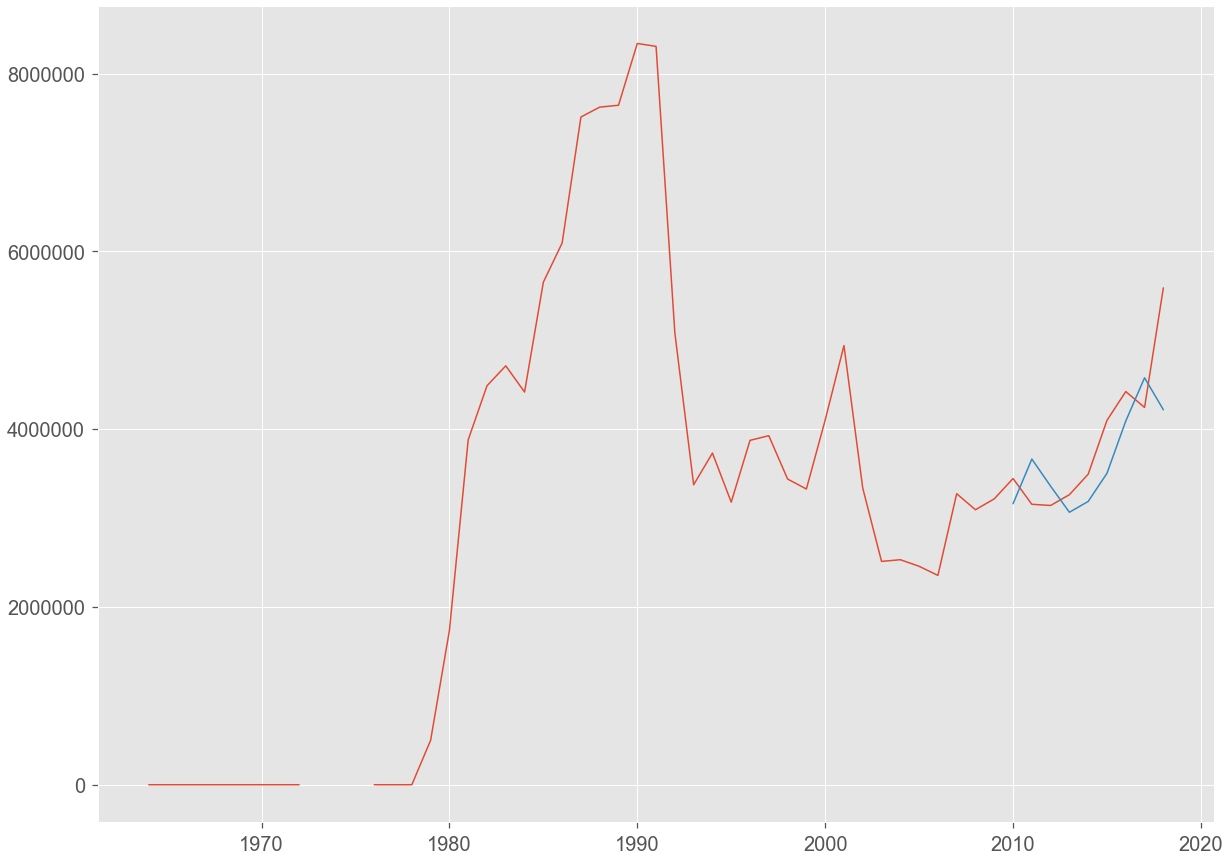

In [24]:
plot_forecast_changes(df, df_acc, 'AFG', 'XGBoost-0.001', 1)

2009 true = 3216014.0
2010 predicted = 3161229.1266601677
2010 true = 3216014.0
2011 predicted = 3380057.5132289054
2011 true = 3216014.0
2012 predicted = 3583809.0326555143
2012 true = 3216014.0
2013 predicted = 3507502.6178074437
2013 true = 3216014.0
2014 predicted = 3431505.482330359
2014 true = 3216014.0
2015 predicted = 3441879.6668419726
2015 true = 3216014.0
2016 predicted = 3434034.4605194367
2016 true = 3216014.0
2017 predicted = 3588568.321075498
2017 true = 3216014.0
2018 predicted = 3562908.8395187375


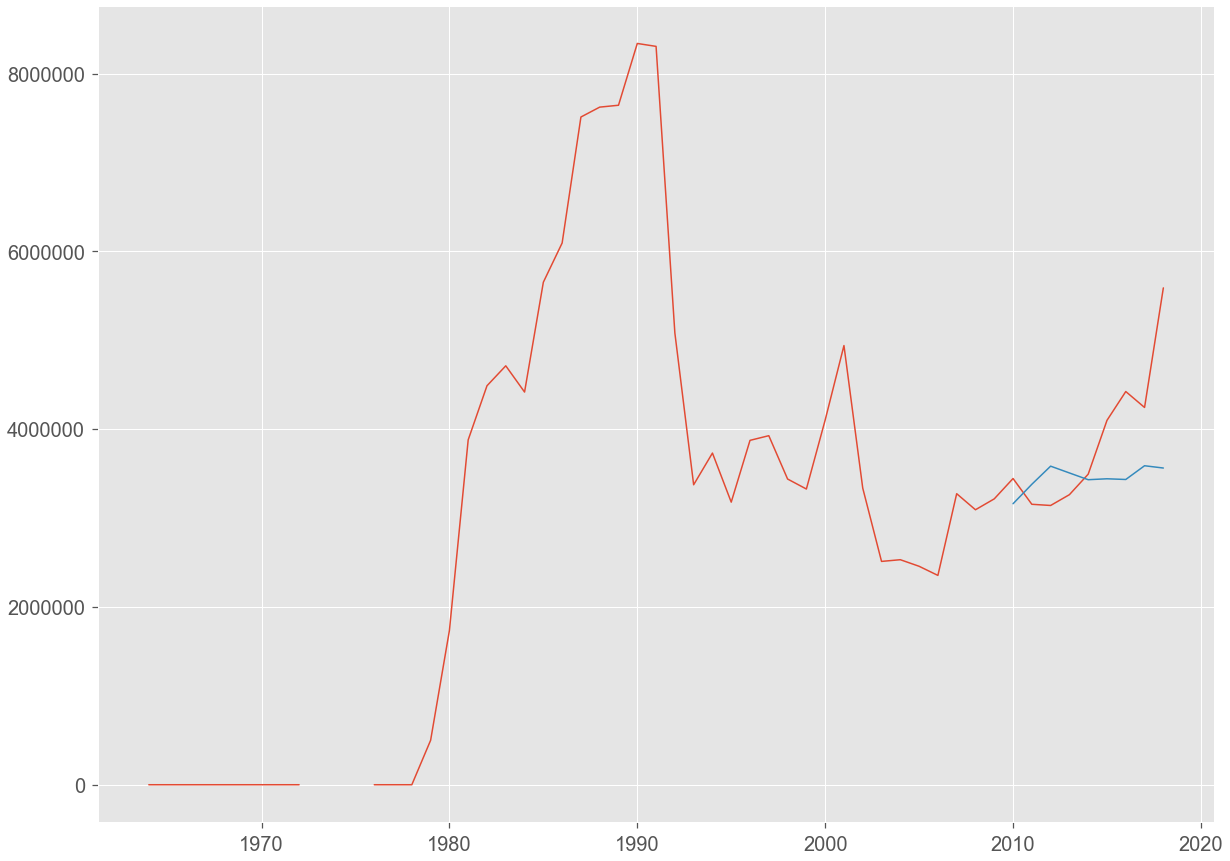

In [25]:
plot_forecast_changes_rec(df, df_acc, 'AFG', 'XGBoost-0.001', 1)

2009 true = 899259.0
2010 predicted = 913096.3021660792
2010 true = 883940.0
2011 predicted = 880453.2129229312
2011 true = 888738.0
2012 predicted = 886980.7745702607
2012 true = 891004.0
2013 predicted = 889584.3631044441
2013 true = 1165796.0
2014 predicted = 1164610.072583238
2014 true = 1175763.0
2015 predicted = 1187237.859270304
2015 true = 1156864.0
2016 predicted = 1161953.2503628943
2016 true = 1190527.0
2017 predicted = 1302357.3912514865
2017 true = 1832945.0
2018 predicted = 1873202.2151334519


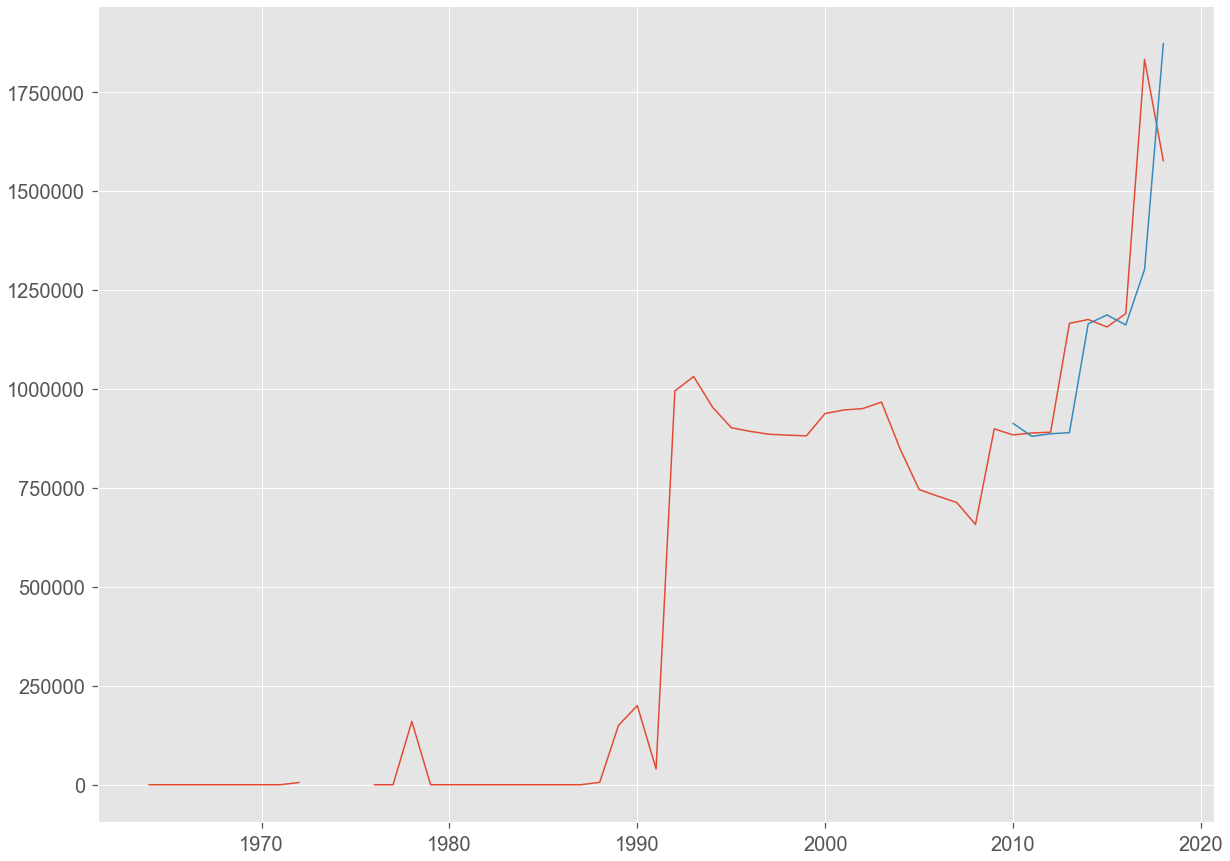

In [26]:
plot_forecast_changes(df, df_acc, 'MMR', 'XGBoost-0.001', 1)

2009 true = 899259.0
2010 predicted = 913096.3021660792
2010 true = 899259.0
2011 predicted = 909609.5150890104
2011 true = 899259.0
2012 predicted = 907852.289659271
2012 true = 899259.0
2013 predicted = 906432.6527637151
2013 true = 899259.0
2014 predicted = 905246.725346953
2014 true = 899259.0
2015 predicted = 916721.5846172571
2015 true = 899259.0
2016 predicted = 921810.8349801515
2016 true = 899259.0
2017 predicted = 1033641.226231638
2017 true = 899259.0
2018 predicted = 1073898.44136509


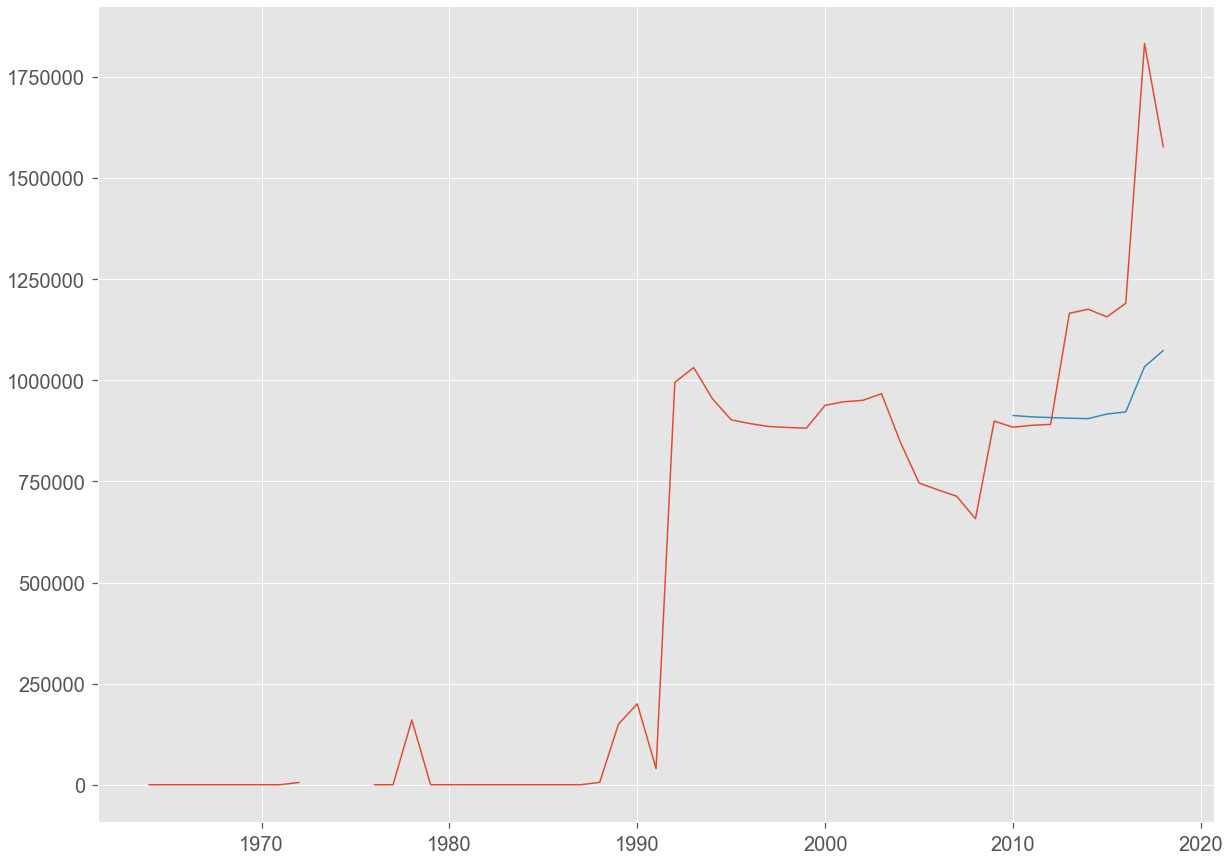

In [27]:
plot_forecast_changes_rec(df, df_acc, 'MMR', 'XGBoost-0.001', 1)